In [1]:
from proj_utils import *
import os, struct
import numpy as np

In [2]:
path = os.path.join(os.path.curdir, 'data')
x_train, y_train = load_NMNIST('training', digits=[0,1,2], path=path)
x_test, y_test = load_NMNIST('testing', digits=[0,1,2], path=path)

In [3]:
#_train = np.reshape(x_train, (len(x_train), 28,28, 1))  # adapt this if using `channels_first` image data format
def aug_img(img):
    img = np.repeat(img.astype(np.uint8), 3, 2)
    img = np.reshape(img, (len(img), 28,28, 3))
    img = resize_data(img)
    return img

In [4]:
x_train = aug_img(x_train)
x_train.shape

(60000, 140, 140, 3)

In [5]:
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
import numpy as np
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
y_train = to_categorical(y_train)
y_train.shape

(60000, 3)

In [7]:
inc_model = InceptionV3(weights='imagenet', include_top=False)

# get layers and add average pooling layer
x = inc_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# add output layer
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=inc_model.input, outputs=predictions)

# freeze pre-trained model area's layer
for layer in inc_model.layers:
    layer.trainable = False

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# update the weight that are added
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(x_train, y_train)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/1
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0857: 0s - loss: 0


In [9]:
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:279]:
    layer.trainable = False

for layer in model.layers[279:]:
    layer.trainable = True

# training
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, shuffle=True,  validation_split=0.15)

Train on 51000 samples, validate on 9000 samples
Epoch 1/5
51000/51000 [==============================] - 88s 2ms/step - loss: 0.0122 - acc: 0.9977 - val_loss: 2.6038e-06 - val_acc: 1.0000
Epoch 2/5
51000/51000 [==============================] - 86s 2ms/step - loss: 3.4585e-04 - acc: 0.9999 - val_loss: 1.3035e-07 - val_acc: 1.0000
Epoch 3/5
51000/51000 [==============================] - 86s 2ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 8.5928e-05 - val_acc: 1.0000
Epoch 4/5
51000/51000 [==============================] - 86s 2ms/step - loss: 4.2138e-04 - acc: 0.9999 - val_loss: 8.4542e-07 - val_acc: 1.0000
Epoch 5/5
51000/51000 [==============================] - 86s 2ms/step - loss: 6.9788e-04 - acc: 0.9999 - val_loss: 1.3731e-05 - val_acc: 1.0000


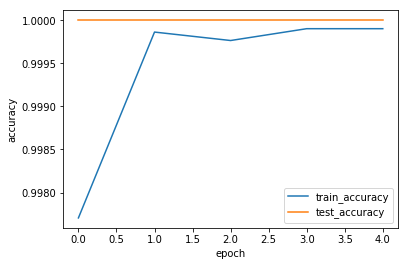

In [10]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

show_history(history)

In [11]:
x_train = y_train = None
x_test = aug_img(x_test)
y_test = to_categorical(y_test)

In [12]:
iv3_test_scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (iv3_test_scores[1]*100))

10000/10000 [==============================] - 18s 2ms/step
Accuracy: 91.66%
